### Import Necessary Packages

In [ ]:
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix
import math as mt
from scipy.sparse.linalg import * #used for matrix multiplication
from scipy.sparse.linalg import svds
from scipy.sparse import csc_matrix

### Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
track_metadata_df = pd.read_csv('')
count_play_df = pd.read_csv('/content/10000.txt', sep='\t', header=None, names=['user','song','play_count'])

In [ ]:
track_metadata_df = pd.read_csv('/content/gdrive/MyDrive/OpenLab/Extra/song_data.csv')
count_play_df =pd.read_csv('/content/gdrive/MyDrive/OpenLab/10000.txt', sep='\t', header=None, names=['user','song','play_count'])

### Song_data.csv

In [ ]:
print('Number of rows:', track_metadata_df.shape[0])
print('Number of unique songs:', len(track_metadata_df.song_id.unique()))
display(track_metadata_df.head())

Number of rows: 1000000
Number of unique songs: 999056


,song_id,title,release,artist_name,year
0,SOQMMHC12AB0180CB8,Silent Night,Monster Ballads X-Mas,Faster Pussy cat,2003
1,SOVFVAK12A8C1350D9,Tanssi vaan,Karkuteillä,Karkkiautomaatti,1995
2,SOGTUKN12AB017F4F1,No One Could Ever,Butter,Hudson Mohawke,2006
3,SOBNYVR12A8C13558C,Si Vos Querés,De Culo,Yerba Brava,2003
4,SOHSBXH12A8C13B0DF,Tangle Of Aspens,Rene Ablaze Presents Winter Sessions,Der Mystic,0


Clearly, we have repeated track metadata.

### 10000.txt

In [ ]:
print('No of rows:', count_play_df.shape[0])
print('Number of unique users:', len(count_play_df.user.unique()))
display(count_play_df.head())

No of rows: 2000000
Number of unique users: 76353


,user,song,play_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1


### Merge Datasets

Merge song_data.csv and 10000.txt based on the song_id.

In [ ]:
track_metadata_df.rename(columns = {'song_id': 'song'},inplace=True)
user_song_list_count = pd.merge(count_play_df, track_metadata_df.drop_duplicates(['song']), on='song', how ='left')
user_song_list_count.rename(columns={'play_count':'listen_count'},inplace=True)
display(user_song_list_count.head())

,user,song,listen_count,title,release,artist_name,year
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Graduation,Kanye West,2007
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,In Between Dreams,Jack Johnson,2005
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999


### Matrix factorization based recommendations

#### Getting fractional listen count of every user:

In [ ]:
user_song_list_listen = user_song_list_count[['user','listen_count']].groupby('user').sum().reset_index()
user_song_list_listen.rename(columns={'listen_count':'total_listen_count'},inplace=True)
#display(user_song_list_listen.head(3))

user_song_list_count_merged = pd.merge(user_song_list_count,user_song_list_listen)
#display(user_song_list_count_merged.head())

user_song_list_count_merged['fractional_play_count'] = user_song_list_count_merged['listen_count']/user_song_list_count_merged['total_listen_count']

#### Displaying fractional count for a single user:

In [ ]:
display(user_song_list_count_merged[user_song_list_count_merged.user ==\
                                    'd6589314c0a9bcbca4fee0c93b14bc402363afea'][['user','song','listen_count','fractional_play_count','total_listen_count']].head())

,user,song,listen_count,fractional_play_count,total_listen_count
299,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOADQPP12A67020C82,12,0.038961,308
300,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAFTRR12AF72A8D4D,1,0.003247,308
301,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOANQFY12AB0183239,1,0.003247,308
302,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAYATB12A6701FD50,1,0.003247,308
303,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOBOAFP12A8C131F36,7,0.022727,308


#### Displaying merged table which consists of fractional playcount and listen count additionally.

In [ ]:
display(user_song_list_count_merged.head(3))

,user,song,listen_count,title,release,artist_name,year,total_listen_count,fractional_play_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0,71,0.014085
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976,71,0.028169
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Graduation,Kanye West,2007,71,0.014085


#### Creating Utility Matrix:

#### Extending user_song_list_count_merged table to small_set table which adds indices for each user to track.

In [ ]:
user_codes = user_song_list_count_merged.user.drop_duplicates().reset_index()
#display(user_codes)

user_codes.rename(columns={'index':'user_index'}, inplace=True)
user_codes['us_index_value'] = list(user_codes.index)
display(user_codes)

,user_index,user,us_index_value
0,0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,0
1,45,85c1f87fea955d09b4bec2e36aee110927aedf9a,1
2,46,bd4c6e843f00bd476847fb75c47b4fb430a06856,2
3,54,8937134734f869debcab8f23d77465b4caaa85df,3
4,56,969cc6fb74e076a68e36a04409cb9d3765757508,4
...,...,...,...
76348,1999874,391de020bddab59d1927ff4884cbebf8797df289,76348
76349,1999883,9a51c7b254e90470fff3d34ef5cc516d21633471,76349
76350,1999905,a955513fb89fdb0d5e8437a5cf8a9b3a0abad4d5,76350
76351,1999918,276e43ad698705e5011e5091f367d951b21246f5,76351


In [ ]:
song_codes = user_song_list_count_merged.song.drop_duplicates().reset_index()
song_codes.rename(columns={'index':'song_index'}, inplace=True)

song_codes['so_index_value'] = list(song_codes.index)
display(song_codes)

,song_index,song,so_index_value
0,0,SOAKIMP12A8C130995,0
1,1,SOBBMDR12A8C13253B,1
2,2,SOBXHDL12A81C204C0,2
3,3,SOBYHAJ12A6701BF1D,3
4,4,SODACBL12A8C13C273,4
...,...,...,...
9995,176740,SOQYVCY12A8C13AA92,9995
9996,188475,SORHFLF12A6D4F7429,9996
9997,209505,SOXWEPM12AB0181694,9997
9998,222753,SOGYQGZ12AB017E08A,9998


In [ ]:
small_set = pd.merge(user_song_list_count_merged,song_codes,how='left')
#display(small_set.columns)
small_set = pd.merge(small_set,user_codes,how='left')
display(small_set.head())
small_set.shape

,user,song,listen_count,title,release,artist_name,year,total_listen_count,fractional_play_count,song_index,so_index_value,user_index,us_index_value
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0,71,0.014085,0,0,0,0
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976,71,0.028169,1,1,0,0
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Graduation,Kanye West,2007,71,0.014085,2,2,0,0
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,In Between Dreams,Jack Johnson,2005,71,0.014085,3,3,0,0
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999,71,0.014085,4,4,0,0


(2000000, 13)

Generating mat_candidate which consists of just user indices, song indices and fractional play count

In [ ]:
mat_candidate = small_set[['us_index_value','so_index_value','fractional_play_count']]
display(mat_candidate)

,us_index_value,so_index_value,fractional_play_count
0,0,0,0.014085
1,0,1,0.028169
2,0,2,0.014085
3,0,3,0.014085
4,0,4,0.014085
...,...,...,...
1999995,76352,7159,0.015625
1999996,76352,1315,0.031250
1999997,76352,2965,0.023438
1999998,76352,1363,0.007812


Sparse Matrix generation:

In [ ]:
data_array =mat_candidate.fractional_play_count.values
row_array = mat_candidate.us_index_value.values
col_array = mat_candidate.so_index_value.values
data_sparse = coo_matrix((data_array, (row_array, col_array)),dtype=float)
data_sparse.shape

(76353, 10000)

data_array[i] is value at (row_array[i], col_array[i]) position when using Coordinate Format (COO) to generate sparse matrix


### SVD algorithm implementation through factorisation:

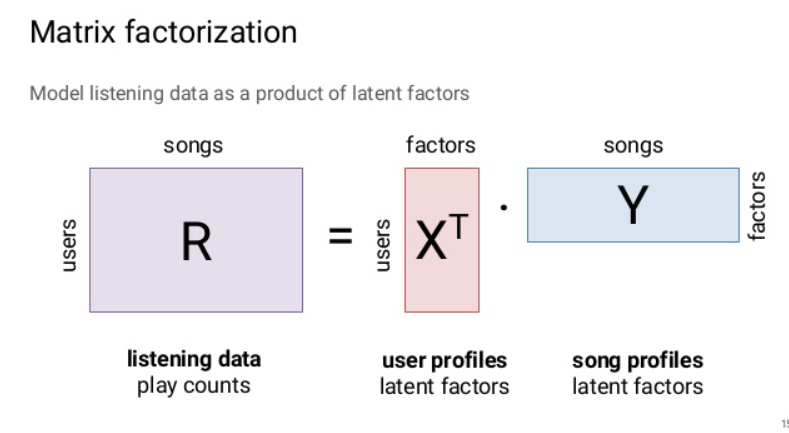

#### **compute_svd:**
It use the svds function provided by the scipy library to break down our utility matrix into three different matrices.

#### **compute_estimated_matrix:** 
Use the decomposed matrices by SVD and provide the predictions.

Compressed Sparse Column Format (CSC)

[SVD explained](https://jonathan-hui.medium.com/machine-learning-singular-value-decomposition-svd-principal-component-analysis-pca-1d45e885e491)

In [ ]:
K=50
urm = data_sparse
MAX_PID = urm.shape[1]
MAX_UID = urm.shape[0]

In [ ]:
def compute_svd(urm, K):
    U, s, Vt = svds(urm, K)
    #urm=U*S*Vt
    # s is the list of eigen values corresponding to urm*urmT, its length is equal to K
    dim = (len(s), len(s))
    S = np.zeros(dim, dtype=np.float32)
    for i in range(0, len(s)):
        S[i,i] = mt.sqrt(s[i])
    #print("Shape of S",S.shape)
    #print("Shape of V", Vt.shape)
    U = csc_matrix(U, dtype=np.float32)
    S = csc_matrix(S, dtype=np.float32)
    Vt = csc_matrix(Vt, dtype=np.float32)
    
    return U, S, Vt

In [ ]:
def compute_estimated_matrix(urm, U, S, Vt, uTest, K, test):
    rightTerm = S*Vt 
    max_recommendation = 250
    estimatedRatings = np.zeros(shape=(MAX_UID, MAX_PID), dtype=np.float16)
    recomendRatings = np.zeros(shape=(MAX_UID,max_recommendation ), dtype=np.float16)
    for userTest in uTest:
        prod = U[userTest, :]*rightTerm
        estimatedRatings[userTest, :] = prod.todense()
        recomendRatings[userTest, :] = (-estimatedRatings[userTest, :]).argsort()[:max_recommendation] #ranking, descending order, selecting first recommmendations' indices in estimated rankings
    return recomendRatings

In [ ]:
def show_recomendations(uTest, num_recomendations = 10):
    for user in uTest:
        print('-'*70)
        print("Recommendation for user id {}".format(user))
        rank_value = 1
        i = 0
        while (rank_value <  num_recomendations + 1):
            so = uTest_recommended_items[user,i:i+1][0]
            if (small_set.user[(small_set.so_index_value == so) & (small_set.us_index_value == user)].count()==0):
                song_details = small_set[(small_set.so_index_value == so)].\
                    drop_duplicates('so_index_value')[['title','artist_name']]
                print("The number {} recommended song is {} BY {}".format(rank_value, 
                                                                      list(song_details['title'])[0],
                                                                      list(song_details['artist_name'])[0]))
                rank_value+=1
            i += 1

#### Showing Recommendations:

In [ ]:
U, S, Vt = compute_svd(urm, K)
uTest = [4,5,6,7,8,873,23]
uTest2=[1,2,3,4,5]
uTest3=[4,5,6,7,8,9,10]
uTest_recommended_items = compute_estimated_matrix(urm, U, S, Vt, uTest, K, True)
#uTest_recommended_items.shape
#show_recomendations(uTest2)
show_recomendations(uTest3)
show_recomendations(uTest)

----------------------------------------------------------------------
Recommendation for user id 4
The number 1 recommended song is 911 BY Wyclef Jean / Mary J. Blige
The number 2 recommended song is If I Ain't Got You BY Alicia Keys
The number 3 recommended song is Sample Track 2 BY Simon Harris
The number 4 recommended song is Kennedy Rag BY Suzy Thompson
The number 5 recommended song is Clocks BY Coldplay
The number 6 recommended song is Yellow BY Coldplay
The number 7 recommended song is Hey_ Soul Sister BY Train
The number 8 recommended song is The Scientist BY Coldplay
The number 9 recommended song is Eco BY Jorge Drexler
The number 10 recommended song is Kryptonite BY 3 Doors Down
----------------------------------------------------------------------
Recommendation for user id 5
The number 1 recommended song is Eenie Meenie BY Sean Kingston and Justin Bieber
The number 2 recommended song is Sample Track 2 BY Simon Harris
The number 3 recommended song is U Smile BY Justin Bieber

In [ ]:
show_recomendations([8765])

----------------------------------------------------------------------
Recommendation for user id 8765
The number 1 recommended song is The Cove BY Jack Johnson
The number 2 recommended song is The Cove BY Jack Johnson
The number 3 recommended song is The Cove BY Jack Johnson
The number 4 recommended song is The Cove BY Jack Johnson
The number 5 recommended song is The Cove BY Jack Johnson
The number 6 recommended song is The Cove BY Jack Johnson
The number 7 recommended song is The Cove BY Jack Johnson
The number 8 recommended song is The Cove BY Jack Johnson
The number 9 recommended song is The Cove BY Jack Johnson
The number 10 recommended song is The Cove BY Jack Johnson


Generating recommendations for a single user:

In [ ]:
uTest = [0]
#Get estimated rating for test user
print("Predictied ratings:")
uTest_recommended_items = compute_estimated_matrix(urm, U, S, Vt, uTest, K, True)
show_recomendations(uTest)

Predictied ratings:
----------------------------------------------------------------------
Recommendation for user id 0
The number 1 recommended song is Basic Space BY The xx
The number 2 recommended song is Infinity BY The xx
The number 3 recommended song is I Wanna Be Sedated (Remastered Album Version ) BY Ramones
The number 4 recommended song is Fantasy BY The xx
The number 5 recommended song is The Big Gundown BY The Prodigy
The number 6 recommended song is CIEÑ BY Milczenie Owiec
The number 7 recommended song is Home BY Edward Sharpe & The Magnetic Zeros
The number 8 recommended song is Cosmic Love BY Florence + The Machine
The number 9 recommended song is Speak BY Godsmack
The number 10 recommended song is You've Got The Love BY Florence + The Machine
